In [42]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import shap

from sklearn.preprocessing import LabelEncoder
from swifter import swiftapply

#アルゴリズム
#https://lightgbm.readthedocs.io/en/latest/
import lightgbm as lgb


from sklearn.model_selection import train_test_split,StratifiedKFold#
#評価指標
from sklearn.metrics import accuracy_score,roc_auc_score

#可視化
%matplotlib inline
import matplotlib.pyplot as plt

seed=2018
strkfold=StratifiedKFold(n_splits=10,shuffle=True,random_state=seed)

"""
評価手法
'accuracy'
"""
scoring_method='accuracy'

#https://www.kaggle.com/uciml/mushroom-classification
df = pd.read_csv('./data/mushrooms.csv', header=0)
#欠損確認
df.isnull().sum()

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

In [43]:
#カテゴリ処理。このデータは全カラムがカテゴリ。
#Kaggleでよく見かけるやり方
"""
for col in df.columns:
    le=LabelEncoder()
    le.fit(df[col])
    df[col]=le.transform(df[col])
"""
#今回はswiftapplyを使ってみる
for col in df.columns:
    le=LabelEncoder()
    df[col]=swiftapply(df[col],le.fit_transform)
df.head()

class  cap-shape  cap-surface  cap-color  bruises  odor  gill-attachment  \
0      1          5            2          4        1     6                1   
1      0          5            2          9        1     0                1   
2      0          0            2          8        1     3                1   
3      1          5            3          8        1     6                1   
4      0          5            2          3        0     5                1   

   gill-spacing  gill-size  gill-color   ...     stalk-surface-below-ring  \
0             0          1           4   ...                            2   
1             0          0           4   ...                            2   
2             0          0           5   ...                            2   
3             0          1           5   ...                            2   
4             1          0           4   ...                            2   

   stalk-color-above-ring  stalk-color-below-ring  veil-type  veil-color  \
0                       7                       7          0           2   
1                       7                       7          0           2   
2                       7                       7          0           2   
3                       7                       7          0           2   
4                       7                       7          0           2   

   ring-number  ring-type  spore-print-color  population  habitat  
0            1          4                  2           3        5  
1            1          4                  3           2        1  
2            1          4                  3           2        3  
3            1          4                  2           3        5  
4            1          0                  3           0        1  

[5 rows x 23 columns]

In [44]:
#テストデータと評価用データに分割
df,df_s=train_test_split(df,test_size=0.2,random_state=1)
df=df.reset_index(drop=True)
df_s=df_s.reset_index(drop=True)
df.head()

class  cap-shape  cap-surface  cap-color  bruises  odor  gill-attachment  \
0      0          5            0          4        0     5                1   
1      0          5            2          3        0     5                1   
2      1          5            3          2        0     8                1   
3      1          5            2          2        0     8                1   
4      0          5            0          4        1     5                1   

   gill-spacing  gill-size  gill-color   ...     stalk-surface-below-ring  \
0             1          0           4   ...                            2   
1             1          0           4   ...                            2   
2             0          1           0   ...                            1   
3             0          1           0   ...                            2   
4             0          0          10   ...                            2   

   stalk-color-above-ring  stalk-color-below-ring  veil-type  veil-color  \
0                       7                       7          0           2   
1                       7                       7          0           2   
2                       6                       6          0           2   
3                       6                       6          0           2   
4                       3                       3          0           2   

   ring-number  ring-type  spore-print-color  population  habitat  
0            1          0                  2           0        1  
1            1          0                  2           3        1  
2            1          0                  7           4        0  
3            1          0                  7           4        2  
4            1          4                  3           4        0  

[5 rows x 23 columns]

In [45]:
#pandas_profittingで確認した結果veil-typeはすべての値がpなのでDropする。
X=df.drop(["class","veil-type"],axis=1)
y=df["class"]

X_s=df_s.drop(["class","veil-type"],axis=1)
y_s=df_s["class"]


In [55]:
#ハイパーパラメータ
best = {'boosting_type': 'dart', 'max_depth': 11,  'min_data_in_leaf': 1055, 'n_estimators': 80.0, 'objective': 'binary', 'seed': 2018, 'tree_learner': 'feature'}
nrounds=int(best['n_estimators'])

In [56]:
#XgboostLike
for train_index, test_index in strkfold.split(X, y):
    X_train, X_eval = X.iloc[train_index], X.iloc[test_index]
    y_train, y_eval = y[train_index], y[test_index]
    lgb_train = lgb.Dataset(X_train, label=y_train.ravel(),feature_name=list(X.columns.values))
    lgb_eval =lgb.Dataset(X_eval, label=y_eval.ravel())
    lgb_model = lgb.train(best, lgb_train, nrounds, 
                    lgb_eval, verbose_eval=1, 
                              early_stopping_rounds=20)

[1]	valid_0's binary_logloss: 0.646278
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's binary_logloss: 0.607885
[3]	valid_0's binary_logloss: 0.558399
[4]	valid_0's binary_logloss: 0.529023
[5]	valid_0's binary_logloss: 0.49199
[6]	valid_0's binary_logloss: 0.467495
[7]	valid_0's binary_logloss: 0.426549
[8]	valid_0's binary_logloss: 0.392012
[9]	valid_0's binary_logloss: 0.364033
[10]	valid_0's binary_logloss: 0.337968
[11]	valid_0's binary_logloss: 0.316466
[12]	valid_0's binary_logloss: 0.297708
[13]	valid_0's binary_logloss: 0.279716
[14]	valid_0's binary_logloss: 0.264977
[15]	valid_0's binary_logloss: 0.25097
[16]	valid_0's binary_logloss: 0.241274
[17]	valid_0's binary_logloss: 0.230196
[18]	valid_0's binary_logloss: 0.221451
[19]	valid_0's binary_logloss: 0.21401
[20]	valid_0's binary_logloss: 0.205385
[21]	valid_0's binary_logloss: 0.210519
[22]	valid_0's binary_logloss: 0.216028
[23]	valid_0's binary_logloss: 0.208529
[24]	valid_0's binary_logloss:

[38]	valid_0's binary_logloss: 0.176242
[39]	valid_0's binary_logloss: 0.171981
[40]	valid_0's binary_logloss: 0.17508
[41]	valid_0's binary_logloss: 0.177667
[42]	valid_0's binary_logloss: 0.174031
[43]	valid_0's binary_logloss: 0.176747
[44]	valid_0's binary_logloss: 0.172313
[45]	valid_0's binary_logloss: 0.168604
[46]	valid_0's binary_logloss: 0.170792
[47]	valid_0's binary_logloss: 0.165546
[48]	valid_0's binary_logloss: 0.161846
[49]	valid_0's binary_logloss: 0.158564
[50]	valid_0's binary_logloss: 0.160861
[51]	valid_0's binary_logloss: 0.15799
[52]	valid_0's binary_logloss: 0.160921
[53]	valid_0's binary_logloss: 0.157582
[54]	valid_0's binary_logloss: 0.159779
[55]	valid_0's binary_logloss: 0.1564
[56]	valid_0's binary_logloss: 0.153407
[57]	valid_0's binary_logloss: 0.150467
[58]	valid_0's binary_logloss: 0.151663
[59]	valid_0's binary_logloss: 0.152402
[60]	valid_0's binary_logloss: 0.148662
[61]	valid_0's binary_logloss: 0.146299
[62]	valid_0's binary_logloss: 0.148173
[63]

[76]	valid_0's binary_logloss: 0.13259
[77]	valid_0's binary_logloss: 0.13391
[78]	valid_0's binary_logloss: 0.132228
[79]	valid_0's binary_logloss: 0.129379
[80]	valid_0's binary_logloss: 0.131083
Did not meet early stopping. Best iteration is:
[79]	valid_0's binary_logloss: 0.129379
[1]	valid_0's binary_logloss: 0.646172
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's binary_logloss: 0.60816
[3]	valid_0's binary_logloss: 0.555721
[4]	valid_0's binary_logloss: 0.530875
[5]	valid_0's binary_logloss: 0.490528
[6]	valid_0's binary_logloss: 0.467893
[7]	valid_0's binary_logloss: 0.42558
[8]	valid_0's binary_logloss: 0.393974
[9]	valid_0's binary_logloss: 0.362081
[10]	valid_0's binary_logloss: 0.338175
[11]	valid_0's binary_logloss: 0.313658
[12]	valid_0's binary_logloss: 0.295239
[13]	valid_0's binary_logloss: 0.276132
[14]	valid_0's binary_logloss: 0.261736
[15]	valid_0's binary_logloss: 0.249921
[16]	valid_0's binary_logloss: 0.23807
[17]	valid_0's binary_lo

[31]	valid_0's binary_logloss: 0.169991
[32]	valid_0's binary_logloss: 0.170259
[33]	valid_0's binary_logloss: 0.164698
[34]	valid_0's binary_logloss: 0.159766
[35]	valid_0's binary_logloss: 0.162677
[36]	valid_0's binary_logloss: 0.158597
[37]	valid_0's binary_logloss: 0.160856
[38]	valid_0's binary_logloss: 0.15618
[39]	valid_0's binary_logloss: 0.15249
[40]	valid_0's binary_logloss: 0.155782
[41]	valid_0's binary_logloss: 0.158018
[42]	valid_0's binary_logloss: 0.15325
[43]	valid_0's binary_logloss: 0.156419
[44]	valid_0's binary_logloss: 0.151827
[45]	valid_0's binary_logloss: 0.148466
[46]	valid_0's binary_logloss: 0.150634
[47]	valid_0's binary_logloss: 0.145789
[48]	valid_0's binary_logloss: 0.141938
[49]	valid_0's binary_logloss: 0.13905
[50]	valid_0's binary_logloss: 0.141518
[51]	valid_0's binary_logloss: 0.137724
[52]	valid_0's binary_logloss: 0.140803
[53]	valid_0's binary_logloss: 0.137264
[54]	valid_0's binary_logloss: 0.13945
[55]	valid_0's binary_logloss: 0.136751
[56]	

[69]	valid_0's binary_logloss: 0.128789
[70]	valid_0's binary_logloss: 0.130609
[71]	valid_0's binary_logloss: 0.12805
[72]	valid_0's binary_logloss: 0.125394
[73]	valid_0's binary_logloss: 0.122668
[74]	valid_0's binary_logloss: 0.124323
[75]	valid_0's binary_logloss: 0.122682
[76]	valid_0's binary_logloss: 0.12103
[77]	valid_0's binary_logloss: 0.122251
[78]	valid_0's binary_logloss: 0.119723
[79]	valid_0's binary_logloss: 0.118432
[80]	valid_0's binary_logloss: 0.120091
Did not meet early stopping. Best iteration is:
[79]	valid_0's binary_logloss: 0.118432


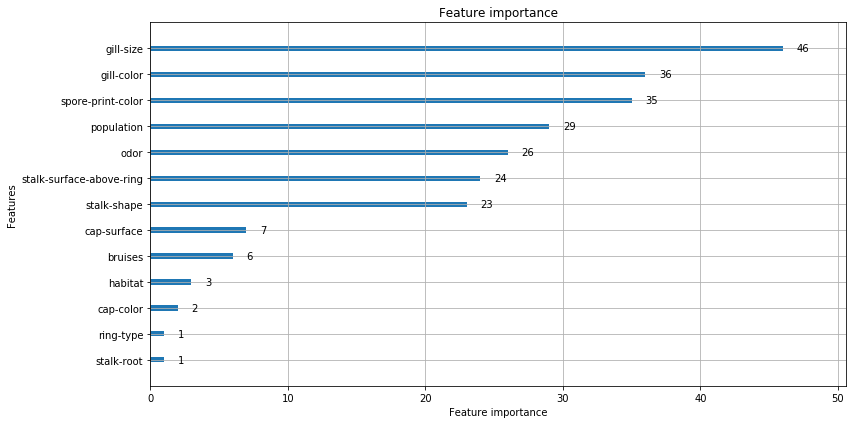

In [57]:
import matplotlib.pyplot as plt
lgb.plot_importance(lgb_model, figsize=(12, 6))
plt.tight_layout()#見切れ防止
plt.savefig("Native_LightGBM.png")
plt.show()

In [58]:
# load JS visualization code to notebook
shap.initjs()
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X)
# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [59]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X)

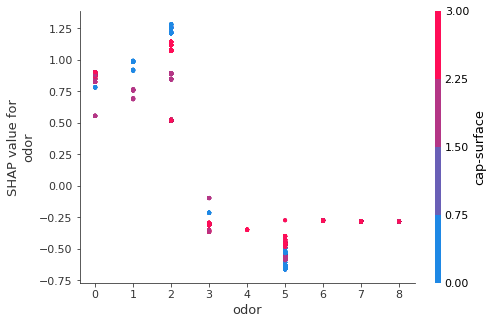

In [51]:
shap.dependence_plot("odor", shap_values, X)

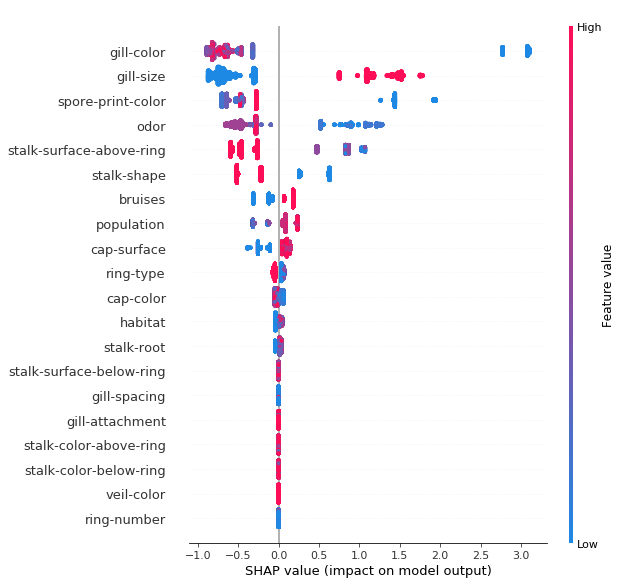

In [52]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X)

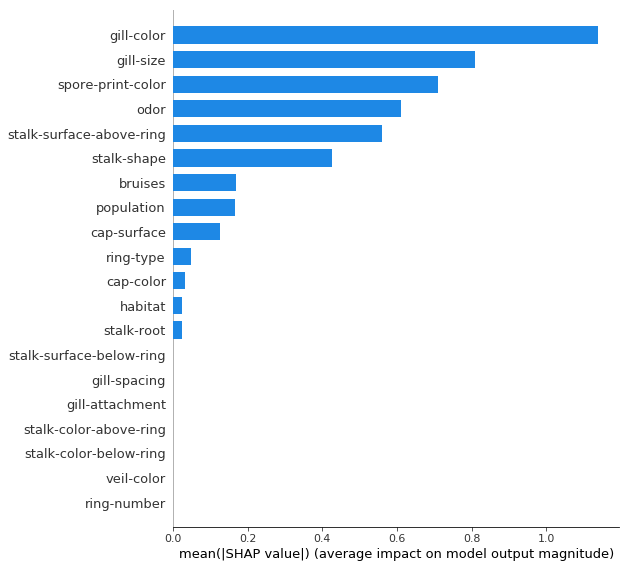

In [53]:
shap.summary_plot(shap_values, X, plot_type="bar")

In [54]:
y_pred= lgb_model.predict(X_s, num_iteration=lgb_model.best_iteration)
#LightGBMはデフォルトでは予測確率を返すためnumpyで変換。
y_pred=np.where(y_pred < 0.5, 0, 1)

#評価
print(accuracy_score(y_s,y_pred))

0.9772307692307692
